In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, feature_extraction, preprocessing, svm, pipeline, metrics, tree, linear_model
import json
import matplotlib.pyplot as plt
import itertools
from project_utilities import plot_confusion_matrix
import time

# Raw Data

In [2]:
with open('train_data.json') as fd:
    train_data = pd.DataFrame(json.load(fd))
    
with open('test_data.json') as fd:
    test_data = pd.DataFrame(json.load(fd))

It's good to use 80% and 20% of the dataset for training and testing respectively.

In [3]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
    train_data.drop(columns=['category']), 
    train_data.drop(columns=['text']), 
    test_size=0.2)

# Experimenting with Different Classifiers

The following experiments are already using pipelining. The pipeline structures the raw data. It also extracts and selects features from the structured data.

## Logistic Regression

In [4]:
clf_pipeline_logistic_reg = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', linear_model.LogisticRegression())])

clf_pipeline_logistic_reg.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [5]:
logistic_reg_predictions = clf_pipeline_logistic_reg.predict(X_validation['text'])

print(metrics.classification_report(y_validation, logistic_reg_predictions,digits=5))

             precision    recall  f1-score   support

          0    0.86251   0.84678   0.85457      2467
          1    0.85337   0.86854   0.86089      2533

avg / total    0.85788   0.85780   0.85777      5000



## Decision Tree

In [9]:
clf_pipeline_tree = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', tree.DecisionTreeClassifier())])
start = time.time()
clf_pipeline_tree.fit(X_train['text'], y_train);

### Prediction on Validation Set

In [10]:
tree_predictions = clf_pipeline_tree.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, tree_predictions,digits=5))
print("time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.69373   0.69964   0.69667      2467
          1    0.70502   0.69917   0.70208      2533

avg / total    0.69945   0.69940   0.69941      5000

time: 34.20586156845093


## SVM

In [11]:
clf_pipeline_svm = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [12]:
svm_predictions = clf_pipeline_svm.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_predictions,digits=5))
print("time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.89413   0.88326   0.88866      2467
          1    0.88763   0.89814   0.89286      2533

avg / total    0.89084   0.89080   0.89079      5000

time: 9.880055665969849


# Experimenting with Different Feature Extraction Pipelines

## Binary Occurences

In [13]:
clf_pipeline_svm_bin = pipeline.Pipeline([
    ('vect', feature_extraction.text.HashingVectorizer(binary=True)),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_bin.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [14]:
svm_bin_predictions = clf_pipeline_svm_bin.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_bin_predictions,digits=5))
print("Time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.88880   0.88772   0.88826      2467
          1    0.89077   0.89183   0.89130      2533

avg / total    0.88980   0.88980   0.88980      5000

Time: 5.79531192779541


## TF-IDF Weighting

In [15]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [16]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.89767   0.88893   0.89328      2467
          1    0.89284   0.90130   0.89705      2533

avg / total    0.89522   0.89520   0.89519      5000

Time: 6.5923686027526855


## Custom Parameters
These parameters will used in GridResearch and RandomResearch to see if they can improve accuracy.<br>

textblob_tokenizer, stemming_tokenizer, token.tokenize, and nltk.word_tokenize are the custom paramerters for the tokenizing process in CountVectorizer.

In [17]:
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
import re
porter_stemmer = PorterStemmer()

# Try TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

# Try NLTK's PorterStemmer
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [19]:
import nltk
nltk.download('punkt');

[nltk_data] Downloading package punkt to /home/michael/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### SVM+OccurenceCount+TF*IDF+textblob tokenizer

In [20]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = textblob_tokenizer)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.89053   0.88042   0.88545      2467
          1    0.88481   0.89459   0.88967      2533

avg / total    0.88763   0.88760   0.88759      5000

Time: 205.21311378479004


### SVM+OccurenceCount+TF*IDF+stemming tokenizer

In [22]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = stemming_tokenizer)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.89126   0.88042   0.88581      2467
          1    0.88490   0.89538   0.89011      2533

avg / total    0.88804   0.88800   0.88799      5000

Time: 125.80776953697205


### SVM+OccurenceCount+TF*IDF+nltk.word tokenize

In [24]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = nltk.word_tokenize)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.90574   0.89582   0.90075      2467
          1    0.89961   0.90920   0.90438      2533

avg / total    0.90263   0.90260   0.90259      5000

Time: 43.77820324897766


### SVM+OccurenceCount+TF*IDF+token.tokenize

In [32]:
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [34]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = token.tokenize)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.90004   0.89420   0.89711      2467
          1    0.89761   0.90328   0.90043      2533

avg / total    0.89881   0.89880   0.89879      5000

Time: 4.118284463882446


## Using TF-IDF and Linear SVM

In [31]:
clf_pipeline_svm = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = token.tokenize)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])

parameters = {'vect__ngram_range': [(1,1), (1,2), (2,2)],
              'vect__binary': [True],
              'vect__analyzer':['word'],
              'vect__strip_accents': ['unicode'],
              'tfidf__norm': ['l1'],
              'tfidf__smooth_idf': [False],
              'clf__C':[1, 10],}

### With Randomized Search CV

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from scipy.stats import uniform

seed = 42

random_search = RandomizedSearchCV(clf_pipeline_svm, param_distributions = parameters, cv=2, verbose = 0, random_state = seed, n_iter = 5)
random_search.fit(X_train['text'], y_train)

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

RandomizedSearchCV(cv=2, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'vect__binary': [True], 'vect__analyzer': ['word'], 'vect__strip_accents': ['unicode'], 'tfidf__norm': ['l1'], 'tfidf__smooth_idf': [False], 'clf__C': [1, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

#### Prediction on Validation Set

In [37]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [38]:
y_pred_randcv = random_search.predict(X_validation['text'])
report(y_pred_randcv)
print(metrics.classification_report(y_validation, y_pred_randcv))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### With Grid Search CV

This is our best classifier so far!

In [39]:
grid_search_cv = model_selection.GridSearchCV(clf_pipeline_svm, parameters, cv=2, n_jobs=6, verbose=10, error_score=0)
grid_search_cv.fit(X_train['text'], y_train)

print('Best Parameters:', grid_search_cv.best_params_);

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 1), vect__strip_accents=unicode 
[CV] clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 1), vect__strip_accents=unicode 
[CV] clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 2), vect__strip_accents=unicode 
[CV] clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 2), vect__strip_accents=unicode 


/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(2, 2), vect__strip_accents=unicode 
[CV]  clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 1), vect__strip_accents=unicode, score=0.8833116688331167, total=   8.5s


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   12.6s


[CV]  clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 1), vect__strip_accents=unicode, score=0.8832883288328833, total=   8.7s
[CV] clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(2, 2), vect__strip_accents=unicode 


/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 1), vect__strip_accents=unicode 


/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 1), vect__strip_accents=unicode 
[CV]  clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 1), vect__strip_accents=unicode, score=0.8713128687131287, total=  13.3s


[Parallel(n_jobs=6)]: Done   3 out of  12 | elapsed:   43.9s remaining:  2.2min


[CV]  clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 2), vect__strip_accents=unicode, score=0.8992100789921008, total=  28.7s
[CV]  clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 2), vect__strip_accents=unicode, score=0.8980898089808981, total=  29.1s


[Parallel(n_jobs=6)]: Done   5 out of  12 | elapsed:   46.9s remaining:  1.1min
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 2), vect__strip_accents=unicode 
[CV]  clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(2, 2), vect__strip_accents=unicode, score=0.8842115788421158, total=  24.5s
[CV] clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 2), vect__strip_accents=unicode 
[CV]  clf__C=1, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(2, 2), vect__strip_accents=unicode, score=0.8834883488348835, total=  23.6s


[Parallel(n_jobs=6)]: Done   7 out of  12 | elapsed:   49.4s remaining:   35.3s


[CV] clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(2, 2), vect__strip_accents=unicode 
[CV]  clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 1), vect__strip_accents=unicode, score=0.871987198719872, total=  10.7s
[CV] clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(2, 2), vect__strip_accents=unicode 


/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

[CV]  clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(2, 2), vect__strip_accents=unicode, score=0.8856114388561144, total=  27.8s


[Parallel(n_jobs=6)]: Done   9 out of  12 | elapsed:  1.4min remaining:   28.3s


[CV]  clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(2, 2), vect__strip_accents=unicode, score=0.8845884588458846, total=  28.1s
[CV]  clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 2), vect__strip_accents=unicode, score=0.9019098090190981, total=  36.6s
[CV]  clf__C=10, tfidf__norm=l1, tfidf__smooth_idf=False, vect__analyzer=word, vect__binary=True, vect__ngram_range=(1, 2), vect__strip_accents=unicode, score=0.8986898689868987, total=  36.7s


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.5min finished
/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'clf__C': 10, 'tfidf__norm': 'l1', 'tfidf__smooth_idf': False, 'vect__analyzer': 'word', 'vect__binary': True, 'vect__ngram_range': (1, 2), 'vect__strip_accents': 'unicode'}


#### Prediction on Validation Set

In [40]:
predictions = grid_search_cv.predict(X_validation['text'])

print(metrics.classification.classification_report(y_validation, predictions))

             precision    recall  f1-score   support

          0       0.92      0.91      0.92      2467
          1       0.92      0.93      0.92      2533

avg / total       0.92      0.92      0.92      5000



## Confusion Matrix Visualization

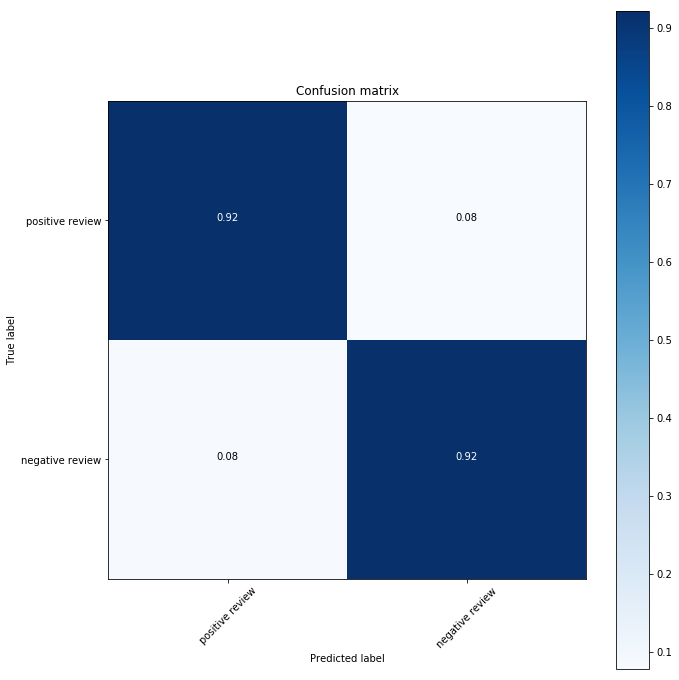

In [41]:
plot_confusion_matrix(metrics.confusion_matrix(predictions, y_validation), ['positive review', 'negative review'], normalize=True)

# Prediction on Test Set Using Our Best Classifier

In [14]:
test_set_predictions = grid_search_cv.predict(test_data['text'])

data = {'Id' : test_data['id'], 'Category': test_set_predictions}
submission = pd.DataFrame(data=data)
submission = submission.apply(pd.to_numeric).sort_values(by=['Id'])

In [15]:
submission.to_csv('submission.csv', encoding='utf-8', index=False)